In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as spo
import scipy.stats as sts
plt.style.use('seaborn')

# Pressure Analysis from the Ground Up
This notebook follows all the steps of the pressure data analysis from `Data_Analysis.ipynb` as transparently and simply as possible. The notebook will be written in an order following the conceptual steps in the analysis, rather than separating plots and code.

## Data Import
Data is imported from an HDF5 file previously generated in the `Import_Data.ipynb` notebook. Change the run label to match the name of the h5 file.

In [56]:
run_label = '2021_05_06' ## Change this to look at different runs
hdf_name = '{}_clean_data.h5'.format(run_label)

The HDF5 file stores data for each of the five gases with the name of the gas as the key. This notebook imports each table by key into a list of `pandas` tables in order of molecular weight.

|Index|Gas           |
|-----|--------------|
|0    |Hydrogen      |
|1    |Water Vapor   |
|2    |Nitrogen      |
|3    |Oxygen        |
|4    |Carbon Dioxide|

In [57]:
gases = ['H2', 'H2O', 'N2', 'O2', 'CO2']
gas_tables = [] # appendable list of gas data tables from HDF5

for gas in gases:
    gas_tables.append(pd.read_hdf(hdf_name, key=gas))

Checking the CO2 table:

In [58]:
gas_tables[4]

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp
3130008,46.0,3.760000e-07,295.8,296.0,295.90
8222757,88.0,3.150000e-07,295.8,296.0,295.90
7719329,129.0,2.920000e-07,295.8,296.0,295.90
1031070,171.0,2.560000e-07,295.8,296.0,295.90
3747401,212.0,2.340000e-07,295.8,296.0,295.90
...,...,...,...,...,...
6511300,357377.0,1.670000e-09,298.2,298.2,298.20
1514678,357419.0,1.910000e-09,298.2,298.1,298.15
4670022,357460.0,1.700000e-09,298.2,298.2,298.20
8207892,357502.0,1.600000e-09,298.2,298.2,298.20


## The Pressure Fitting Function
This is the fitting function for a single jump in temperature:
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$
In order to use `scipy.optimize.curve_fit` with this function, the values of $t$ and $T$ must be input as a numpy array of shape `(k, M)` where `k` is the number of predictors and `M` is the sample size. This is from the [curve_fit documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [59]:
def pressure_fit(tT, A, b, c):
    """Outputs the partial pressure for a given time (after the start of the temperature jump) and temperature.
    
    Arguments:
    tT: a (2,M) numpy array of time and temperature values, where M is the number of observations in the jump.
    A: the scaling parameter for the jump. Accounts for variables such as the initial concentration, etc.
    b: the activation energy (multiplied by k_B) in kelvins.
    c: the time constant which is proportional to the diffusion constant."""
    
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

## Analysis of a Single Jump

### Finding the Jumps
For now, jumps are found manually by plotting the temperature vs. time for a gas and successively narrowing the time window until a single smooth curve is found. I've been using $CO_2$ as the gas of choice to find these jumps, but all the gases should give the same answers.

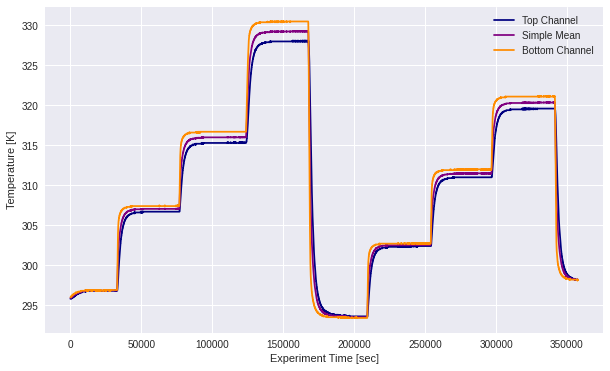

In [60]:
checked_bounds = [0, 999999]
CO2_jump_table = gas_tables[4][gas_tables[4]['exp_time'].between(checked_bounds[0], checked_bounds[1])]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(CO2_jump_table['exp_time'], CO2_jump_table['ch1_lerp'], color='navy', label='Top Channel')
ax.plot(CO2_jump_table['exp_time'], CO2_jump_table['mean_temp'], color='purple', label='Simple Mean')
ax.plot(CO2_jump_table['exp_time'], CO2_jump_table['ch2_lerp'], color='darkorange', label='Bottom Channel')

#ax.set_title('$CO_2$ Temperature vs. Time, Hunting for Jumps')
ax.set_xlabel('Experiment Time [sec]')
ax.set_ylabel('Temperature [K]')
ax.legend()

plt.show()

### Full Pressure Plot

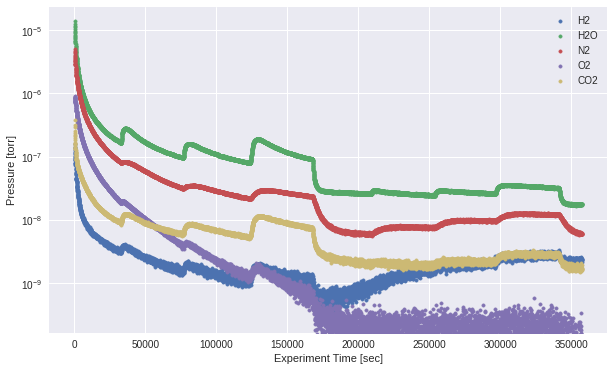

In [61]:
fig, ax = plt.subplots(figsize=(10,6))
for idx, gas in enumerate(['H2', 'H2O', 'N2', 'O2', 'CO2']):
    ax.scatter(gas_tables[idx]['exp_time'], gas_tables[idx]['pressure'], marker='.', label=gas)

#ax.scatter(gas_tables[3]['exp_time'], gas_tables[3]['pressure'], marker='.', label=gases[3])

#ax.set_ylim(1e-8, 1e-7)
ax.set_ylabel('Pressure [torr]')
ax.set_xlabel('Experiment Time [sec]')
ax.set_yscale('log')
ax.legend()

plt.show()

As the bounds of a given jump are found, place them into a nested list.

In [62]:
jump_bounds = [[33100, 76800], [76801, 123800], [123801, 167600], [209300, 254000], [254001, 296800], [296801, 341400]]

Note that since data is taken once every 41 or 42 seconds, double-counting data points would be very unlikely; however, just to be sure, I had each jump start at least "one second" after the previous one.

### Jump-Fitting Example: CO2 Jump 5
Jump 4 of the $CO_2$ pressure data has a long enough fall time to make it the best jump in the dataset to fit. We'll build up the analysis of it first and then generalize.

#### Extract Jump Data from Gas Table
We can use the `between` function from Pandas series to extract the experiment time, top temperature, and pressure from the jump.

In [63]:
CO2_jump4_table = gas_tables[4][gas_tables[4]['exp_time'].between(jump_bounds[1][0], jump_bounds[1][1])].reset_index(drop=True)
CO2_jump4_table

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp
0,76816.0,5.940000e-09,306.70,307.6,307.150
1,76858.0,6.040000e-09,306.70,307.9,307.300
2,76899.0,6.250000e-09,306.75,308.2,307.475
3,76941.0,6.000000e-09,306.80,308.6,307.700
4,76982.0,6.130000e-09,306.80,309.0,307.900
...,...,...,...,...,...
1129,123616.0,5.460000e-09,315.30,316.7,316.000
1130,123658.0,5.150000e-09,315.30,316.7,316.000
1131,123699.0,5.460000e-09,315.30,316.7,316.000
1132,123740.0,5.390000e-09,315.30,316.7,316.000


We need the time to be shifted so that the first data point is the start time of the jump. We do this by finding the smallest value of `exp_time` and subtracting it.

In [64]:
CO2_jump4_table['exp_time'].min()

76816.0

In [65]:
CO2_jump4_table['jump_time'] = CO2_jump4_table['exp_time'] - CO2_jump4_table['exp_time'].min()
CO2_jump4_table

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp,jump_time
0,76816.0,5.940000e-09,306.70,307.6,307.150,0.0
1,76858.0,6.040000e-09,306.70,307.9,307.300,42.0
2,76899.0,6.250000e-09,306.75,308.2,307.475,83.0
3,76941.0,6.000000e-09,306.80,308.6,307.700,125.0
4,76982.0,6.130000e-09,306.80,309.0,307.900,166.0
...,...,...,...,...,...,...
1129,123616.0,5.460000e-09,315.30,316.7,316.000,46800.0
1130,123658.0,5.150000e-09,315.30,316.7,316.000,46842.0
1131,123699.0,5.460000e-09,315.30,316.7,316.000,46883.0
1132,123740.0,5.390000e-09,315.30,316.7,316.000,46924.0


#### Getting the Pressure Fit Inputs
The fitting function will need the time and temperature data (`tT`) as a numpy array of shape `(2,M)` and the observed pressure data `press_obs` as a numpy array of shape `(M,)`.

In [66]:
CO2_jump4_tT = CO2_jump4_table[['jump_time', 'ch1_lerp']].T.to_numpy() # we're using the top temperature channel for now
CO2_jump4_press_obs = CO2_jump4_table['pressure'].to_numpy()

print('tT shape: {}\nPressure shape: {}'.format(CO2_jump4_tT.shape, CO2_jump4_press_obs.shape))

tT shape: (2, 1134)
Pressure shape: (1134,)


#### Optimization
We can now optimize over these inputs. The initial parameter guess will be based on previous fits.

In [67]:
init_params = [7, 1900, 0.005]

In [68]:
CO2_jump4_fit = spo.curve_fit(pressure_fit, CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params, maxfev=100000)

In [69]:
CO2_jump4_fit[0]

array([4.77593169e-04, 3.42095742e+03, 6.50655634e-01])

#### Generate Predicted Values
We can calculate the pressure fits with a regular function call using the fit values.

In [70]:
CO2_jump4_pred = pressure_fit(CO2_jump4_tT, *CO2_jump4_fit[0])

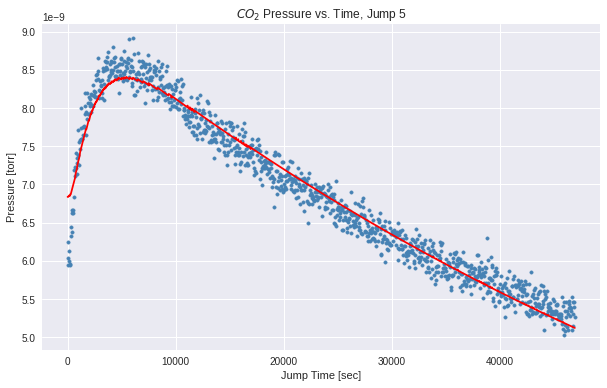

In [71]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4_tT[0], CO2_jump4_press_obs, marker='.', color='steelblue')
ax.plot(CO2_jump4_tT[0], CO2_jump4_pred, color='red')

#ax2 = ax.twinx()
#ax2.plot(CO2_jump4_tT[0], CO2_jump4_table['ch2_lerp'], color='darkorange')
#ax2.plot(CO2_jump4_tT[0], CO2_jump4_table['mean_temp'], color='purple')
#ax2.plot(CO2_jump4_tT[0], CO2_jump4_tT[1], color='navy')
#ax2.set_ylabel('Temperature [Kelvin]')

ax.set_title('$CO_2$ Pressure vs. Time, Jump 5')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Pressure [torr]')
#ax.set_yscale('log')

plt.show()

Here is the corresponding residual plot.

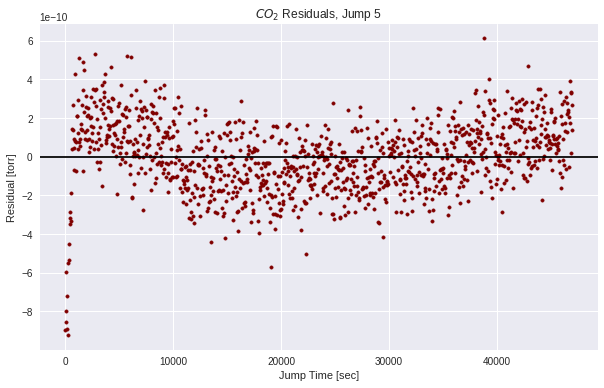

In [72]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4_tT[0], CO2_jump4_press_obs-CO2_jump4_pred, marker='.', color='maroon')
ax.axhline(color='k')

ax.set_title('$CO_2$ Residuals, Jump 5')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Residual [torr]')

plt.show()

#### Single-Jump $\chi^2$ Scan
For now, we set the bounds of the scan to be $\pm5\%$ for $b$, and $\pm10\%$ for $c$.

In [86]:
scan_center = (CO2_jump4_fit[0][1], CO2_jump4_fit[0][2]) # scan center (b, c)
scan_b_bounds = [0.9*scan_center[0], 1.1*scan_center[0]]
scan_c_bounds = [0.5*scan_center[1], 1.5*scan_center[1]]

For the scan, we need to be able to pressure fit for a fixed pair $(b, c)$, so we'll use the `lambda` function. First, we check that this works for a singe pair.

In [87]:
# single pair fixed (b, c) fitting
single_fixed_fit = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, scan_center[0], scan_center[1]), CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params[0], maxfev=100000)
single_fixed_fit[0] # same result?

array([0.00047759])

The syntax seems to work beause we got the same answer for the parameter $A$. Now let's generalize to a $75\times 75$ scan.

In [88]:
scan_b_points = np.linspace(scan_b_bounds[0], scan_b_bounds[1], num=75)
scan_c_points = np.linspace(scan_c_bounds[0], scan_c_bounds[1], num=75)

In [89]:
chi_sq = np.zeros((scan_b_points.shape[0], scan_c_points.shape[0]))
pressure_err = 2e-10 # eyeballed from the residual plot

for x, b in enumerate(scan_b_points):
    for y, c in enumerate(scan_c_points):
        scan_point_fit = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, b, c), CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params[0], maxfev=100000)
        # calculate predicted pressures
        preds = pressure_fit(CO2_jump4_tT, scan_point_fit[0][0], b, c)
        resids = CO2_jump4_press_obs - preds
        chi_square_stat = np.dot(resids, resids)/(pressure_err**2)
        
        chi_sq[x, y] = chi_square_stat

In [90]:
np.min(chi_sq)

957.805843155012

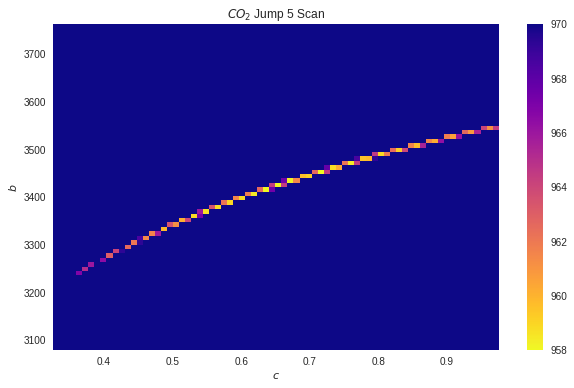

In [91]:
fig, ax = plt.subplots(figsize=(10,6))
CO2_jump4_heat = ax.pcolormesh(scan_c_points, scan_b_points, chi_sq, cmap='plasma_r', vmin=958, vmax=970)

ax.set_title('$CO_2$ Jump 5 Scan')
ax.set_xlabel('$c$')
ax.set_ylabel('$b$')
plt.colorbar(CO2_jump4_heat)

plt.show()

## Analysis of All Jumps
Since we have a list of all jump bounds, we can do a fit over all jumps simultaneously to share a single $b$ and $c$ while allowing different values of A.

In [25]:
CO2_jumps = []
CO2_tT = []

for bound in jump_bounds:
    tab = gas_tables[4][gas_tables[4]['exp_time'].between(bound[0], bound[1])].reset_index(drop=True)
    tab['jump_time'] = tab['exp_time'] - tab['exp_time'].min()
    CO2_jumps.append(tab)
    CO2_tT.append(tab[['jump_time', 'ch1_lerp']].T.to_numpy())

CO2_jumps[0]

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp,jump_time
0,33121.0,3.630000e-09,314.5,316.4,315.45,0.0
1,33162.0,3.450000e-09,314.6,316.4,315.50,41.0
2,33204.0,3.510000e-09,314.6,316.4,315.50,83.0
3,33245.0,3.620000e-09,314.6,316.4,315.50,124.0
4,33287.0,3.510000e-09,314.6,316.4,315.50,166.0
...,...,...,...,...,...,...
1049,76606.0,1.890000e-09,298.0,298.1,298.05,43485.0
1050,76647.0,2.080000e-09,298.0,298.1,298.05,43526.0
1051,76689.0,1.880000e-09,298.0,298.1,298.05,43568.0
1052,76730.0,2.110000e-09,298.0,298.1,298.05,43609.0


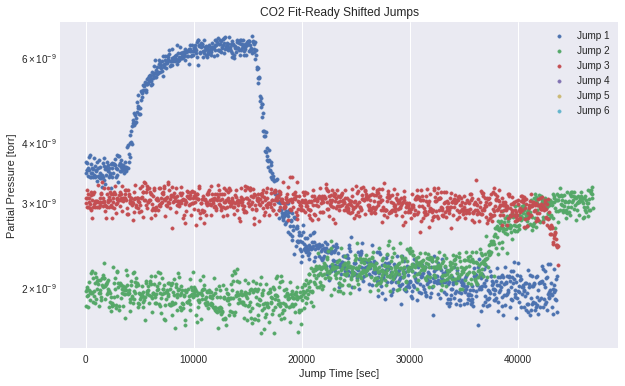

In [26]:
fig, ax = plt.subplots(figsize=(10,6))

for idx, jump in enumerate(CO2_jumps):
    ax.scatter(jump['jump_time'], jump['pressure'], label='Jump {}'.format(idx+1), marker='.')

ax.set_title('CO2 Fit-Ready Shifted Jumps')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Partial Pressure [torr]')
ax.set_yscale('log')
ax.legend()

plt.show()

In [27]:
b = 3.60634884e+03
c = 7.95531434e-02

In [28]:
all_CO2_press = np.concatenate([jump['pressure'].to_numpy() for jump in CO2_jumps])
#all_CO2_press.shape
all_CO2_tT = np.concatenate(CO2_tT, axis=1)
all_CO2_tT.shape

(2, 3244)

In [29]:
def CO2_all_jump_fit(full_tT, b, c):

    all_preds = []
    
    for idx, jump in enumerate(CO2_jumps):
        jump_fixed_fit = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, b, c), CO2_tT[idx], jump['pressure'].to_numpy(), p0=init_params[0], maxfev=100000)
        jump_preds = pressure_fit(CO2_tT[idx], jump_fixed_fit[0][0], b, c)
        all_preds.append(jump_preds)
    
    return np.concatenate(all_preds)

In [30]:
CO2_fit = spo.curve_fit(CO2_all_jump_fit, all_CO2_tT, all_CO2_press, p0=[init_params[1], init_params[2]], maxfev=100000)

ValueError: `ydata` must not be empty!

In [ ]:
CO2_fit[0]

In [ ]:
CO2_fit[1]

In [ ]:
np.sqrt(np.diag(CO2_fit[1]))

Recall that $b=\frac{E_a}{k_B}$, and $c=\frac{\pi^2D_0}{d^2}$. This means that for $CO_2$ and stockroom PTFE,
$$E_a = (0.364\pm 0.005) \text{ eV}$$
$$D_0 = (0.030\pm 0.007)\text{ cm}^2/\text{s}$$
or equivalent
$$E_a^D = (35.1\pm 0.5) \text{ kJ}/\text{mol}$$
$$D_0^D = (30.\pm7) \times 10^{-7} \text{ m}^2/\text{s}$$

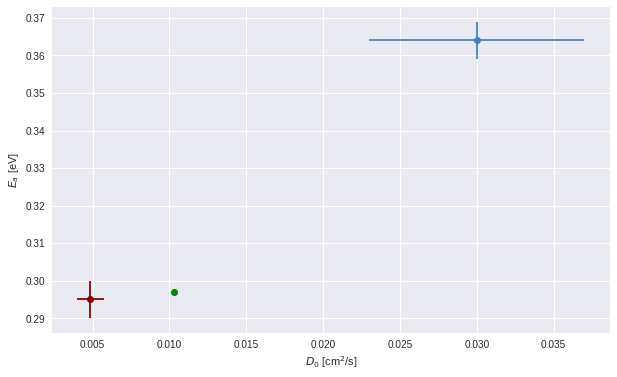

In [36]:
fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(0.03, 0.364, xerr=0.007, yerr=0.005, marker='o', color='steelblue', label='Yale')
ax.errorbar(.00486, 0.295, xerr=8.6e-4, yerr=0.005, marker='o', color='maroon', label='Sebok et al., 2016')
ax.errorbar(.0103, 0.297, marker='o', color='green', label='Pasternak et al., 1970')

ax.set_ylabel('$E_a$ [eV]')
ax.set_xlabel('$D_0$ [cm$^2$/s]')

plt.show()

In [32]:
all_preds = []
for idx, jump in enumerate(CO2_jumps):
    jump_fixed_fit = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, CO2_fit[0][0], CO2_fit[0][1]), CO2_tT[idx], jump['pressure'].to_numpy(), p0=init_params[0], maxfev=100000)
    jump_preds = pressure_fit(CO2_tT[idx], jump_fixed_fit[0][0], CO2_fit[0][0], CO2_fit[0][1])
    all_preds.append(jump_preds)

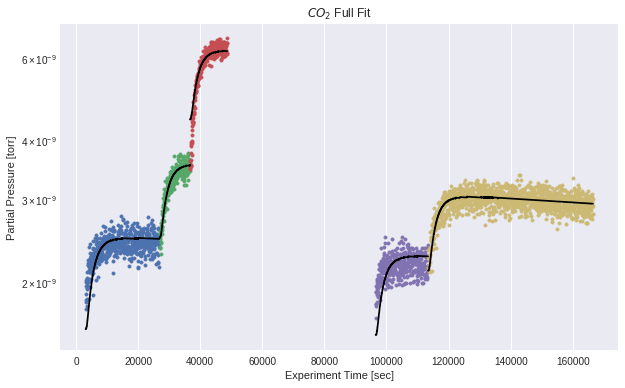

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

for idx, jump in enumerate(CO2_jumps):
    ax.scatter(jump['exp_time'], jump['pressure'].to_numpy(), marker='.')
    ax.plot(jump['exp_time'], all_preds[idx], color='black')

ax.set_title('$CO_2$ Full Fit')
ax.set_xlabel('Experiment Time [sec]')
ax.set_ylabel('Partial Pressure [torr]')
ax.set_yscale('log')

plt.show()

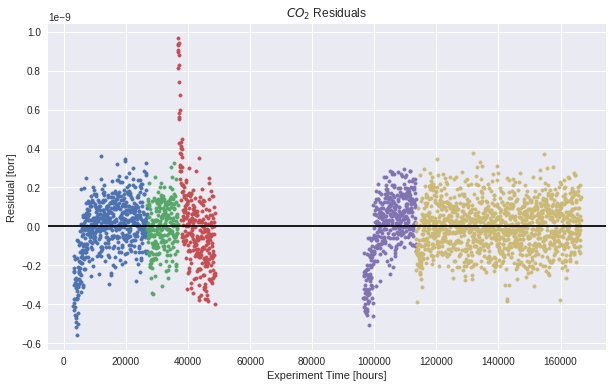

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

for idx, jump in enumerate(CO2_jumps):
    ax.scatter(jump['exp_time'], all_preds[idx]-jump['pressure'].to_numpy(), marker='.')
ax.axhline(color='k')

ax.set_title('$CO_2$ Residuals')
ax.set_xlabel('Experiment Time [hours]')
ax.set_ylabel('Residual [torr]')

plt.show()

#### Full $\chi^2$ Scan

In [35]:
scan_center = (CO2_fit[0][0], CO2_fit[0][1]) # scan center (b, c)
scan_b_bounds = [0.95*scan_center[0], 1.05*scan_center[0]]
scan_c_bounds = [0.75*scan_center[1], 1.25*scan_center[1]]

Generalize to a $75\times 75$ scan.

In [36]:
scan_b_points = np.linspace(scan_b_bounds[0], scan_b_bounds[1], num=75)
scan_c_points = np.linspace(scan_c_bounds[0], scan_c_bounds[1], num=75)

In [37]:
chi_sq = np.zeros((scan_b_points.shape[0], scan_c_points.shape[0]))
pressure_err = 2e-10 # eyeballed from the residual plot

for x, b in enumerate(scan_b_points):
    for y, c in enumerate(scan_c_points):
        # calculate predicted pressures
        preds = CO2_all_jump_fit(all_CO2_tT, b, c)
        resids = all_CO2_press - preds
        chi_square_stat = np.dot(resids, resids)/(pressure_err**2)
        
        chi_sq[x, y] = chi_square_stat

In [38]:
np.min(chi_sq)

1626.0649327690994

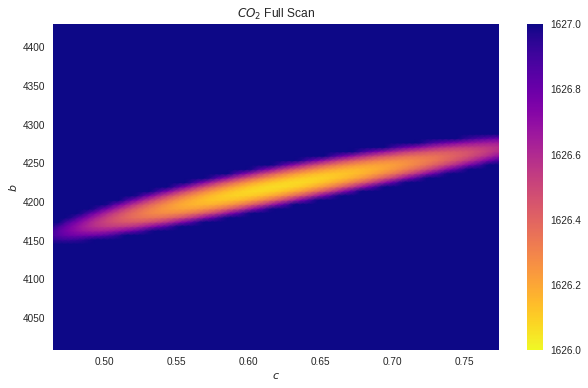

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
CO2_jump4_heat = ax.pcolormesh(scan_c_points, scan_b_points, chi_sq, cmap='plasma_r', shading='gouraud', vmin=1626, vmax=1627)

ax.set_title('$CO_2$ Full Scan')
ax.set_xlabel('$c$')
ax.set_ylabel('$b$')
plt.colorbar(CO2_jump4_heat)

plt.show()

#### Narrowing the Fitting Window
Narrowing the fitting window is no longer seen as a necessary step for this analysis because a different reason for the systematic has since been discovered. If for some reason this code is necessary again, we've kept it commented here.

In [25]:
#j4_window_pct = [.05, .9]
#j4_window_bounds = [int(j4_window_pct[0]*CO2_jump4_press_obs.shape[0]), int(j4_window_pct[1]*CO2_jump4_press_obs.shape[0])]
#j4_window_bounds

In [26]:
#CO2_j4_narrowed_press = CO2_jump4_press_obs[j4_window_bounds[0]:j4_window_bounds[1]]
#CO2_j4_narrowed_tT = CO2_jump4_tT[:, j4_window_bounds[0]:j4_window_bounds[1]]

In [27]:
#CO2_j4_narrowed_fit = spo.curve_fit(pressure_fit, CO2_j4_narrowed_tT, CO2_j4_narrowed_press, p0=init_params, maxfev=100000)

In [28]:
#CO2_j4_narrowed_fit[0]

In [29]:
#CO2_j4_narrowed_pred = pressure_fit(CO2_j4_narrowed_tT, *CO2_j4_narrowed_fit[0])

In [30]:
#fig, ax = plt.subplots(figsize=(10,6))
#ax.scatter(CO2_j4_narrowed_tT[0], CO2_j4_narrowed_press, marker='.', color='steelblue')
#ax.plot(CO2_j4_narrowed_tT[0], CO2_j4_narrowed_pred, color='red')
#
#ax2 = ax.twinx()
#ax2.plot(CO2_j4_narrowed_tT[0], CO2_jump4_table['ch2_lerp'][j4_window_bounds[0]:j4_window_bounds[1]], color='darkorange')
#ax2.plot(CO2_j4_narrowed_tT[0], CO2_jump4_table['mean_temp'][j4_window_bounds[0]:j4_window_bounds[1]], color='purple')
#ax2.plot(CO2_j4_narrowed_tT[0], CO2_j4_narrowed_tT[1], color='navy')
#ax2.set_ylabel('Temperature [Kelvin]')
#
#ax.set_title('$CO_2$ Pressure vs. Time, Narrowed Jump 4')
#ax.set_xlabel('Jump Time [sec]')
#ax.set_ylabel('Pressure [torr]')
#ax.set_yscale('log')
#
#plt.show()

In [31]:
#fig, ax = plt.subplots(figsize=(10,6))
#ax.scatter(CO2_j4_narrowed_tT[0], CO2_j4_narrowed_press-CO2_j4_narrowed_pred, marker='.', color='maroon')
#ax.axhline(color='k')
#
#ax.set_title('$CO_2$ Residuals, Jump 4 Narrowed')
#ax.set_xlabel('Jump Time [sec]')
#ax.set_ylabel('Residual [torr]')
#
#plt.show()

In [32]:
#scan_center = (CO2_j4_narrowed_fit[0][1], CO2_j4_narrowed_fit[0][2]) # scan center (b, c)
#scan_b_bounds = [0.975*scan_center[0], 1.025*scan_center[0]]
#scan_c_bounds = [0.75*scan_center[1], 1.25*scan_center[1]]

$75\times 75$ scan:

In [33]:
#scan_b_points = np.linspace(scan_b_bounds[0], scan_b_bounds[1], num=75)
#scan_c_points = np.linspace(scan_c_bounds[0], scan_c_bounds[1], num=75)

In [34]:
#chi_sq = np.zeros((scan_b_points.shape[0], scan_c_points.shape[0]))
#pressure_err = 1e-9 # eyeballed from the residual plot
#
#for x, b in enumerate(scan_b_points):
#    for y, c in enumerate(scan_c_points):
#        scan_point_fit = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, b, c), CO2_j4_narrowed_tT, CO2_j4_narrowed_press, p0=init_params[0], maxfev=100000)
#        # calculate predicted pressures
#        preds = pressure_fit(CO2_j4_narrowed_tT, scan_point_fit[0][0], b, c)
#        resids = CO2_j4_narrowed_press - preds
#        chi_square_stat = np.dot(resids, resids)/(pressure_err**2)
#        
#        chi_sq[x, y] = chi_square_stat

In [35]:
#pd.DataFrame(chi_sq)

In [36]:
#np.min(chi_sq)

In [37]:
#fig, ax = plt.subplots(figsize=(10,6))
#CO2_jump4_narrowed_heat = ax.pcolormesh(scan_c_points, scan_b_points, chi_sq, vmin=471, vmax=476, cmap='viridis')
#
#ax.set_title('$CO_2$ Jump 4 Narrowed Scan')
#ax.set_xlabel('$c$')
#ax.set_ylabel('$b$')
#plt.colorbar(CO2_jump4_narrowed_heat)
#
#plt.show()

## Checking the Scan of a Synthetic Run

In [ ]:
synth_run = pd.read_csv('synth2.csv', index_col=0)
synth_run

In [ ]:
synth_jump = synth_run.iloc[20:131]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(synth_jump['time'], synth_jump['pressure'], marker='.', color='steelblue')
ax.set_yscale('log')

plt.show()

In [ ]:
synth_jump_TT = synth_jump[['time', 'temperature']].to_numpy().T

In [ ]:
synth_fit = spo.curve_fit(pressure_fit, synth_jump_TT, synth_jump['pressure'], p0=init_params, maxfev=100000)

In [ ]:
synth_fit[0]

In [ ]:
synth_pred = pressure_fit(synth_jump_TT, *synth_fit[0])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(synth_jump['time'], synth_jump['pressure'], marker='.', color='steelblue')
ax.plot(synth_jump['time'], synth_pred, color='red')
#ax.set_yscale('log')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(synth_jump['time'], synth_jump['pressure']-synth_pred, marker='.', color='maroon')
ax.axhline(color='k')

ax.set_title('$CO_2$ Residuals, Synth Jump')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Residual [torr]')

plt.show()

In [ ]:
np.dot(synth_jump['pressure']-synth_pred, synth_jump['pressure']-synth_pred)/(1.0e-6**2)

Single point of a scan to see if the chi-square really is constant across the whole window

In [ ]:
scan_point_fit = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, 1.1*synth_fit[0][1], 1.1*synth_fit[0][2]), synth_jump_TT, synth_jump['pressure'], p0=init_params[0], maxfev=100000)

In [ ]:
scan_point_fit

In [ ]:
scan_point_pred = pressure_fit(synth_jump_TT, scan_point_fit[0][0], 1.1*4.12339864e+03, 1.1*2.22077592e+01)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(synth_jump['time'], synth_jump['pressure'], marker='.', color='steelblue')
ax.plot(synth_jump['time'], scan_point_pred, color='red')
#ax.set_yscale('log')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(synth_jump['time'], synth_jump['pressure']-scan_point_pred, marker='.', color='maroon')
ax.axhline(color='k')

ax.set_title('$CO_2$ Residuals, Synth Jump')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Residual [torr]')

plt.show()

## The New Fitting Function
The old fitting function is the long-time limit which does not apply during the first few days of outgassing. Therefore we must include neglected terms from the Fick's Law solution. Note that this function assumes equilibrium - that is, that the partial pressure is directly proportional to the outgassing rate.
$$p(t,T)=\frac{J}{\kappa}=\frac{4c_0D}{\kappa d}\sum_{n=0}^{\infty}\exp\left\{-\left(\frac{\pi(2n+1)}{d}\right)^2\cdot Dt\right\}$$
where
$$D(T)=D_0\cdot\exp\left({-\frac{E_a}{k_BT}}\right)$$
and where $E_a$ is the activation energy, $D_0$ is the diffusion constant at infinite temperature, $k_B$ is the Boltzmann constant, $d$ is the thickness of the slab, $c_0$ is the initial concentration, and $\kappa$ is the conductance of the chamber.

Let $A=\frac{4c_0D_0}{\kappa d}$, $b=\frac{E_a}{k_B}$, and $c=\frac{\pi^2D_0}{d^2}$. Then
$$p(t,T) = A\cdot\exp\left(-\frac{b}{T}\right)\sum_{n=0}^{\infty}\exp\left\{-(2n+1)^2 ct\cdot\exp\left(-\frac{b}{T}\right)\right\}$$

We can see that both $A$ and $c$ seem to be available for us to measure $D_0$. But what if these two parameters yield conflicting values of $D_0$? The parameter $A$ would probably change to some other constant once $t$ is shifted back. Does this mean we shouldn't shift $t$, or does this show that we should shift it and ignore the value of $A$?

In [34]:
def summative_fit(tT, A, b, c, num_terms=1):
    """Outputs the partial pressure for a given time (after the start of the temperature jump) and temperature.
    
    Arguments:
    tT: a (2,M) numpy array of time and temperature values, where M is the number of observations in the jump.
    A: the scaling parameter for the jump. Accounts for variables such as the initial concentration, etc.
    b: the activation energy (multiplied by k_B) in kelvins.
    c: the time constant which is proportional to the diffusion constant.
    num_terms: number of summation terms to include."""
    
    arrh = np.exp(-1.*b/tT[1]) # factor from the Arrhenius Equation (without D0)
    summation = np.array([np.exp(-1. * (2 * n + 1)**2 * c * tT[0] * arrh) for n in range(num_terms)])
    
    return A * arrh * np.sum(summation, axis=0)

### Application to CO2 Jump 4

In [35]:
CO2_jump4_tT

array([[0.0000e+00, 4.1000e+01, 8.3000e+01, ..., 5.2983e+04, 5.3025e+04,
        5.3066e+04],
       [3.0660e+02, 3.0660e+02, 3.0660e+02, ..., 3.1530e+02, 3.1530e+02,
        3.1530e+02]])

In [36]:
CO2_jump4_press_obs

array([2.14e-09, 2.25e-09, 2.34e-09, ..., 2.80e-09, 2.79e-09, 2.91e-09])

In [37]:
init_params = [7, 1900, 0.005]
CO2_jump4_fit = spo.curve_fit(lambda tT, A, b, c: summative_fit(tT, A, b, c, num_terms=1), CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params, maxfev=100000)

In [38]:
#CO2_jump4_fits

In [39]:
CO2_jump4_pred = summative_fit(CO2_jump4_tT, CO2_jump4_fit[0][0], CO2_jump4_fit[0][1], CO2_jump4_fit[0][2], num_terms=1)

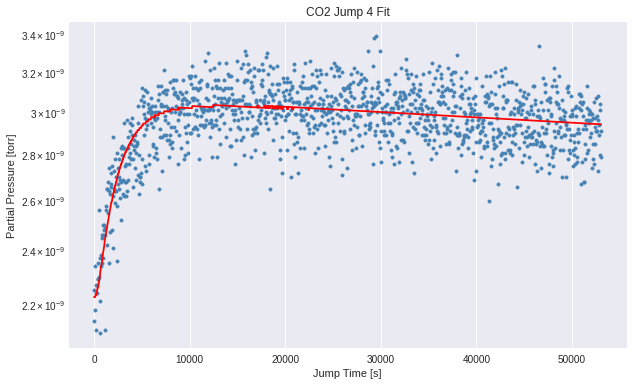

In [40]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_jump4_tT[0], CO2_jump4_press_obs, color='steelblue', marker='.')
ax.plot(CO2_jump4_tT[0], CO2_jump4_pred, color='red')

ax.set_yscale('log')
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Jump Time [s]')
ax.set_title('CO2 Jump 4 Fit')

plt.show()

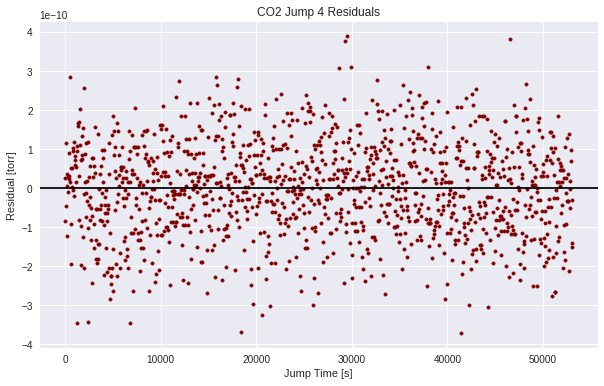

In [41]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_jump4_tT[0], CO2_jump4_press_obs-CO2_jump4_pred, color='maroon', marker='.')
ax.set_ylabel('Residual [torr]')
ax.set_xlabel('Jump Time [s]')
ax.set_title('CO2 Jump 4 Residuals')
ax.axhline(color='k')

plt.show()

In [42]:
nlist = [1, 2, 3, 4, 5, 10, 15, 25, 100]
fits = []
preds = []
for idx, n in enumerate(nlist):
    fits.append(spo.curve_fit(lambda tT, A, b, c: summative_fit(tT, A, b, c, num_terms=n), CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params, maxfev=100000))
    preds.append(summative_fit(CO2_jump4_tT, fits[idx][0][0], fits[idx][0][1], fits[idx][0][2], num_terms=n))

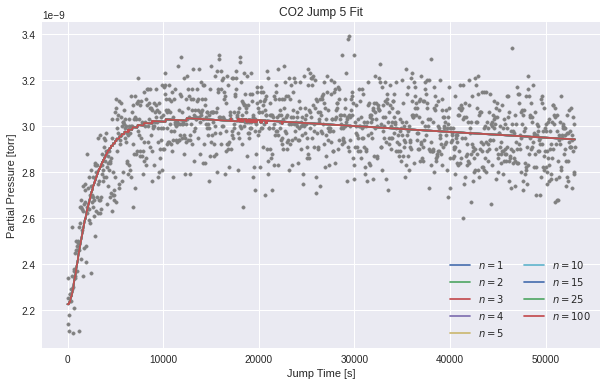

In [56]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(CO2_jump4_tT[0], CO2_jump4_press_obs, color='gray', marker='.')
for idx, pr in enumerate(preds):
    ax.plot(CO2_jump4_tT[0], pr, label="$n = {}$".format(nlist[idx]))

#ax.set_yscale('log')
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Jump Time [s]')
ax.set_title('CO2 Jump 5 Fit')
ax.legend(ncol=2)

plt.show()

## Chi-Square Scan Using New Fitting Function

In [48]:
synth_init_params = [227, 6000, 3000]

In [49]:
synth_run = pd.read_csv('synth_3_exp.csv', index_col=0)
synth_run

,time,temperature,pressure
0,2.0,293.0,4.900767e-05
1,22.0,293.0,1.477625e-05
2,42.0,293.0,1.069590e-05
3,62.0,293.0,8.799523e-06
4,82.0,293.0,7.656078e-06
...,...,...,...
175,3502.0,460.0,5.705305e-10
176,3522.0,460.0,3.373090e-10
177,3542.0,460.0,3.769253e-10
178,3562.0,460.0,2.759318e-11


In [50]:
synth_jump = synth_run.loc[20:131,:]
synth_jump['jump_time'] = synth_jump['time'] - synth_jump['time'].min()
synth_jump

/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,temperature,pressure,jump_time
20,402.0,294.661678,3.641547e-06,0.0
21,422.0,310.395699,5.655859e-06,20.0
22,442.0,324.632431,8.094464e-06,40.0
23,462.0,337.514358,1.089447e-05,60.0
24,482.0,349.170408,1.395674e-05,80.0
...,...,...,...,...
127,2542.0,459.996272,1.221747e-08,2140.0
128,2562.0,459.996627,1.153642e-08,2160.0
129,2582.0,459.996948,9.910394e-09,2180.0
130,2602.0,460.000000,9.347581e-09,2200.0


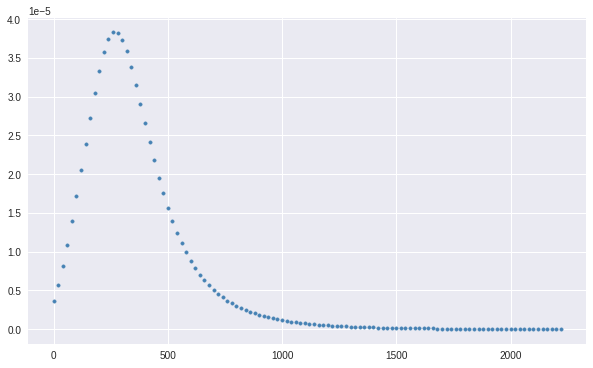

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(synth_jump['jump_time'], synth_jump['pressure'], marker='.', color='steelblue')
#ax.set_yscale('log')

plt.show()

In [52]:
synth_jump_TT = synth_jump[['jump_time', 'temperature']].to_numpy().T
pd.DataFrame(synth_jump_TT)

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,0.000000,20.000000,40.000000,60.000000,80.000000,100.000000,120.000000,140.000000,160.000000,180.000000,...,2040.000000,2060.000000,2080.000000,2100.000000,2120.00000,2140.000000,2160.000000,2180.000000,2200.0,2220.0
1,294.661678,310.395699,324.632431,337.514358,349.170408,359.717238,369.260405,377.895419,385.708703,392.778455,...,459.993854,459.994439,459.994968,459.995447,459.99588,459.996272,459.996627,459.996948,460.0,460.0


In [53]:
SUM_SIZE = 10

In [54]:
synth_fit = spo.curve_fit(lambda tT, A, b, c: summative_fit(tT, A, b, c, num_terms=SUM_SIZE), synth_jump_TT, synth_jump['pressure'], p0=synth_init_params, maxfev=100000)

In [55]:
synth_fit[0]

array([  67.69768296, 5836.06171232, 2078.78775238])

In [56]:
synth_pred = summative_fit(synth_jump_TT, *synth_fit[0], num_terms=SUM_SIZE)

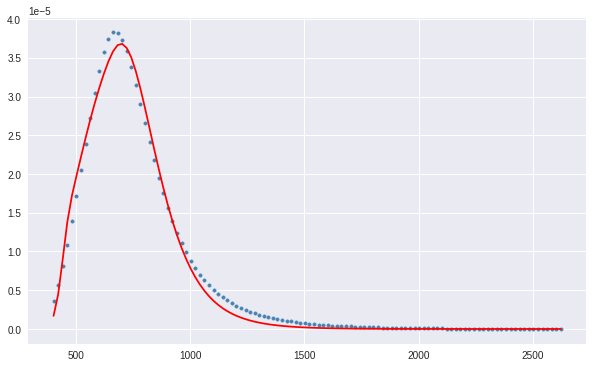

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(synth_jump['time'], synth_jump['pressure'], marker='.', color='steelblue')
ax.plot(synth_jump['time'], synth_pred, color='red')
#ax.set_yscale('log')

plt.show()

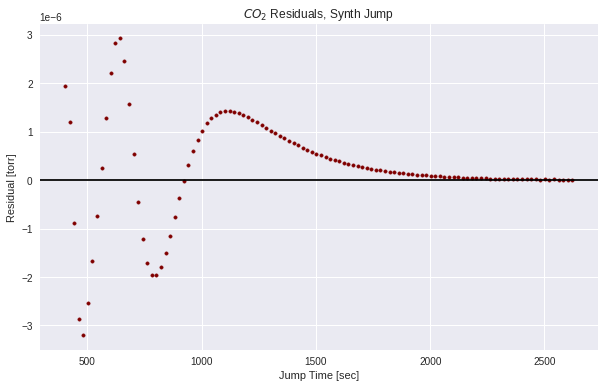

In [58]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(synth_jump['time'], synth_jump['pressure']-synth_pred, marker='.', color='maroon')
ax.axhline(color='k')

ax.set_title('$CO_2$ Residuals, Synth Jump')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Residual [torr]')

plt.show()

In [59]:
np.dot(synth_jump['pressure']-synth_pred, synth_jump['pressure']-synth_pred)/(1.0e-7**2)

12036.69101485202

In [60]:
scan_center = (synth_fit[0][1], synth_fit[0][2]) # scan center (b, c)
scan_b_bounds = [0.99*scan_center[0], 1.01*scan_center[0]]
scan_c_bounds = [0.85*scan_center[1], 1.15*scan_center[1]]

In [61]:
scan_b_points = np.linspace(scan_b_bounds[0], scan_b_bounds[1], num=75)
scan_c_points = np.linspace(scan_c_bounds[0], scan_c_bounds[1], num=75)

In [62]:
chi_sq = np.zeros((scan_b_points.shape[0], scan_c_points.shape[0]))

for x, b in enumerate(scan_b_points):
    for y, c in enumerate(scan_c_points):
        point_fit = spo.curve_fit(lambda tT, A: summative_fit(tT, A, b, c, num_terms=SUM_SIZE), synth_jump_TT, synth_jump['pressure'], p0=synth_init_params[0], maxfev=100000)
        pred = summative_fit(synth_jump_TT, point_fit[0], b, c, num_terms=SUM_SIZE)
        chi_sq[x, y] = np.dot(synth_jump['pressure']-pred, synth_jump['pressure']-pred)/(1.0e-7**2)

chi_sq

array([[12503.36757949, 12366.73011066, 12257.88541472, ...,
        54999.89731997, 56118.43808172, 57246.61603489],
       [12625.06675984, 12467.27453438, 12337.36869911, ...,
        53841.2519325 , 54945.35773575, 56059.18593095],
       [12763.20708669, 12584.2692965 , 12433.31055724, ...,
        52697.94157005, 53787.57986002, 54887.02545079],
       ...,
       [62135.67299375, 60539.92303322, 58976.12699193, ...,
        12091.91006594, 12115.23332184, 12153.38971344],
       [63383.95973184, 61769.43220337, 60186.87847811, ...,
        12086.26683675, 12094.000294  , 12116.62311706],
       [64646.65071386, 63013.40165849, 61412.14524791, ...,
        12096.9013434 , 12089.04683285, 12096.13742017]])

In [63]:
chi_sq.min()

12036.691014852015

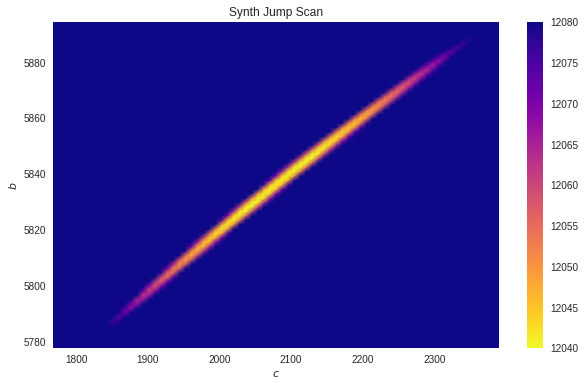

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
synth_heat = ax.pcolormesh(scan_c_points, scan_b_points, chi_sq, vmin=12040, vmax=12080, cmap='plasma_r', shading='gouraud')

ax.set_title('Synth Jump Scan')
ax.set_xlabel('$c$')
ax.set_ylabel('$b$')
plt.colorbar(synth_heat)

plt.show()